# Keras starter kit [full training set, UNet]

## Setup

In [1]:

import numpy as np
import torch
import torch.nn as nn
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pytorch_lightning
import segmentation_models_pytorch as smp
import pytorch_lightning as pl

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import glob
import time
import PIL.Image as Image
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
from sklearn.model_selection import KFold
from tqdm import tqdm
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data


# Data config
# DATA_DIR = '/kaggle/input/vesuvius-challenge-ink-detection/'
DATA_DIR = '/home/fummicc1/codes/competitions/kaggle-ink-detection'
BUFFER = 128  # Half-size of papyrus patches we'll use as model inputs
Z_LIST = list(range(0, 65, 4))  # Offset of slices in the z direction
Z_DIM = len(Z_LIST)  # Number of slices in the z direction. Max value is 64 - Z_START
SHARED_LENGTH = 4000  # Max length(width or height) to resize all papyrii

# Model config
BATCH_SIZE = 64

device = torch.device("cuda")
threshold = 0.5
num_workers = 4
exp = 1e-7

num_epochs = 120
lr = 1e-4

pytorch_lightning.seed_everything(seed=42)
torch.set_float32_matmul_precision('high')

Global seed set to 42


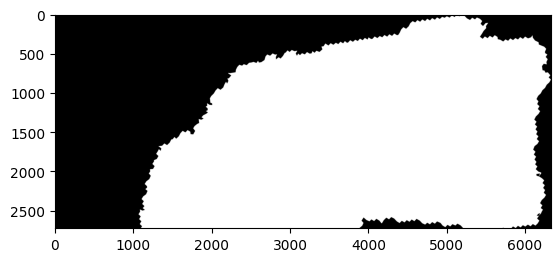

In [2]:
# plt.imshow(Image.open(DATA_DIR + "/train/1/ir.png"), cmap="gray")
# plt.imshow(Image.open(DATA_DIR + "/train/2/ir.png"), cmap="gray")
# plt.imshow(Image.open(DATA_DIR + "/train/3/ir.png"), cmap="gray")
plt.imshow(Image.open(DATA_DIR + "/test/a/mask.png"), cmap="gray")
# plt.imshow(Image.open(DATA_DIR + "/test/b/mask.png"), cmap="gray")

## Load up the training data

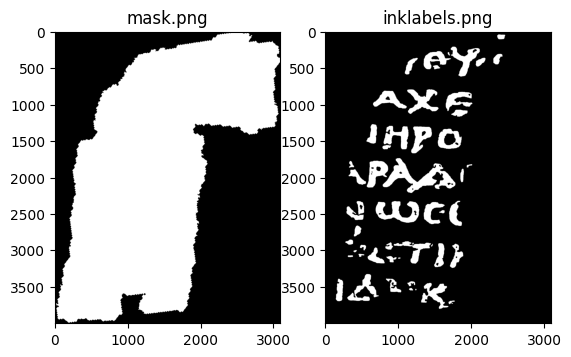

In [3]:
def resize(img):
    current_height, current_width = img.shape    
    aspect_ratio = current_width / current_height
    if current_height > current_width:
        new_height = SHARED_LENGTH
        new_width = int(SHARED_LENGTH * aspect_ratio)
    else:
        new_width = SHARED_LENGTH
        new_height = int(SHARED_LENGTH / aspect_ratio)        
        
    new_size = (new_width, new_height)
    # (W, H)の順で渡すが結果は(H, W)になっている
    img = cv2.resize(img, new_size)
    return img

def load_mask(split, index):
    img = cv2.imread(f"{DATA_DIR}/{split}/{index}/mask.png", 0) // 255
    img = resize(img)    
    return img


def load_labels(split, index):
    img = cv2.imread(f"{DATA_DIR}/{split}/{index}/inklabels.png", 0) // 255
    img = resize(img)
    return img


mask = load_mask(split="train", index=1)
labels = load_labels(split="train", index=1)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("mask.png")
ax1.imshow(mask, cmap='gray')
ax2.set_title("inklabels.png")
ax2.imshow(labels, cmap='gray')
plt.show()

In [4]:
mask_test_a = load_mask(split="test", index="a")
mask_test_b = load_mask(split="test", index="b")

mask_train_1 = load_mask(split="train", index=1)
labels_train_1 = load_labels(split="train", index=1)

mask_train_2 = load_mask(split="train", index=2)
labels_train_2 = load_labels(split="train", index=2)

mask_train_3 = load_mask(split="train", index=3)
labels_train_3 = load_labels(split="train", index=3)

print(f"mask_test_a: {mask_test_a.shape}")
print(f"mask_test_b: {mask_test_b.shape}")
print("-")
print(f"mask_train_1: {mask_train_1.shape}")
print(f"labels_train_1: {labels_train_1.shape}")
print("-")
print(f"mask_train_2: {mask_train_2.shape}")
print(f"labels_train_2: {labels_train_2.shape}")
print("-")
print(f"mask_train_3: {mask_train_3.shape}")
print(f"labels_train_3: {labels_train_3.shape}")

mask_test_a: (1723, 4000)
mask_test_b: (3446, 4000)
-
mask_train_1: (4000, 3094)
labels_train_1: (4000, 3094)
-
mask_train_2: (4000, 2563)
labels_train_2: (4000, 2563)
-
mask_train_3: (4000, 2760)
labels_train_3: (4000, 2760)


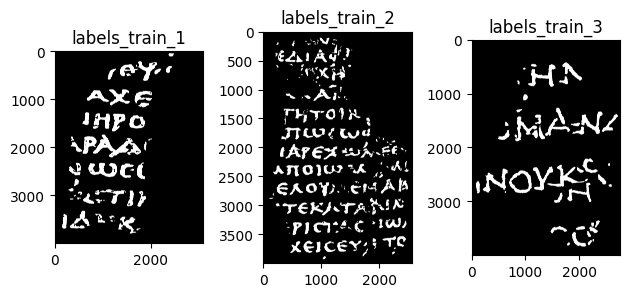

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.set_title("labels_train_1")
ax1.imshow(labels_train_1, cmap='gray')

ax2.set_title("labels_train_2")
ax2.imshow(labels_train_2, cmap='gray')

ax3.set_title("labels_train_3")
ax3.imshow(labels_train_3, cmap='gray')
plt.tight_layout()
plt.show()

In [6]:
def load_volume(split, index):
    # Load the 3d x-ray scan, one slice at a time
    all = sorted(glob.glob(f"{DATA_DIR}/{split}/{index}/surface_volume/*.tif"))
    z_slices_fnames = [all[i] for i in range(len(all)) if i in Z_LIST]
    assert len(z_slices_fnames) == Z_DIM
    z_slices = []
    for z, filename in  tqdm(enumerate(z_slices_fnames)):
        img = cv2.imread(filename, -1)
        img = resize(img)
        img = (img / (2 ** 8)).astype(np.uint8)
        z_slices.append(img)
    return np.stack(z_slices, axis=-1)

In [7]:
volume_train_1 = load_volume(split="train", index=1)
print(f"volume_train_1: {volume_train_1.shape}, {volume_train_1.dtype}")

volume_train_2 = load_volume(split="train", index=2)
print(f"volume_train_2: {volume_train_2.shape}, {volume_train_2.dtype}")

volume_train_3 = load_volume(split="train", index=3)
print(f"volume_train_3: {volume_train_3.shape}, {volume_train_3.dtype}")

volume = np.concatenate([volume_train_1, volume_train_2, volume_train_3], axis=1)
print(f"total volume: {volume.shape}")

17it [00:01,  8.83it/s]


volume_train_1: (4000, 3094, 17), uint8


17it [00:04,  4.15it/s]


volume_train_2: (4000, 2563, 17), uint8


17it [00:01, 11.53it/s]


volume_train_3: (4000, 2760, 17), uint8
total volume: (4000, 8417, 17)


In [8]:
del volume_train_1
del volume_train_2
del volume_train_3

In [9]:
labels = np.concatenate([labels_train_1, labels_train_2, labels_train_3], axis=1)
print(f"labels: {labels.shape}, {labels.dtype}")
mask = np.concatenate([mask_train_1, mask_train_2, mask_train_3], axis=1)
print(f"mask: {mask.shape}, {mask.dtype}")

labels: (4000, 8417), uint8
mask: (4000, 8417), uint8


In [10]:
# Free up memory
del labels_train_1
del labels_train_2
del labels_train_3
del mask_train_1
del mask_train_2
del mask_train_3

## Visualize the training data

In this case, not very informative. But remember to always visualize what you're training on, as a sanity check!

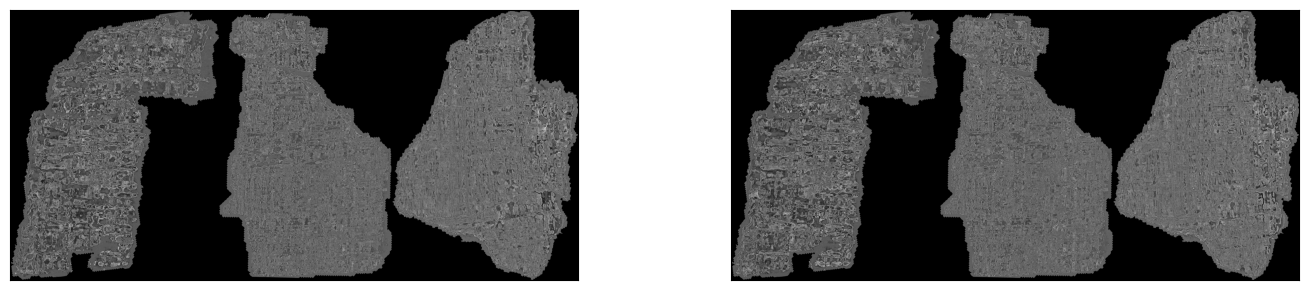

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 3))
for z, ax in enumerate(axes):
    ax.imshow(volume[:, :, z], cmap='gray')
    ax.set_xticks([]); ax.set_yticks([])
fig.tight_layout()
plt.show()

## Create a dataset in the input volume


In [12]:
def is_in_masked_zone(location, mask):
    return mask[location[0], location[1]] > 0


In [13]:
volume.shape

(4000, 8417, 17)

In [14]:
mask.shape

(4000, 8417)

In [15]:
is_in_mask_train = lambda x: is_in_masked_zone(x, mask)

# Create a list to store train locations
locations = []

# Generate train locations
volume_height,volume_width = volume.shape[:-1]

for y in range(BUFFER, volume_height - BUFFER, BUFFER // 3):
    for x in range(BUFFER, volume_width - BUFFER, BUFFER // 3):
        if is_in_mask_train((y, x)):
            locations.append((y, x))

# Convert the list of train locations to a PyTorch tensor
locations_ds = np.stack(locations, axis=0)

In [16]:
locations_ds.shape

(11689, 2)

## Visualize some training patches

Sanity check visually that our patches are where they should be.

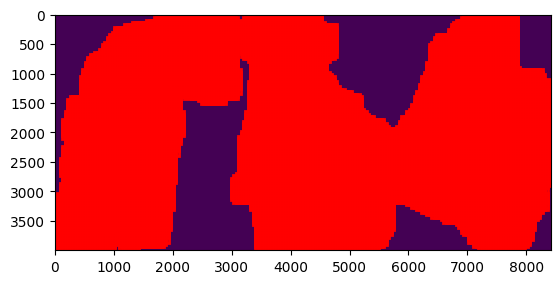

In [17]:
fig, ax = plt.subplots()
ax.imshow(labels)

for y, x in locations_ds:
    patch = Rectangle([x - BUFFER, y - BUFFER], 2 * BUFFER, 2 * BUFFER, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(patch)

plt.show()

In [18]:
from scipy.stats import median_abs_deviation
all_MAD = median_abs_deviation(volume, axis=[0, 1])

In [19]:
all_median = np.median(volume, axis=[0, 1])

In [20]:
mean = np.mean(volume)

In [21]:
mean

61.35099029275486

In [22]:
std = np.std(volume)

In [23]:
std

51.65583796031338

In [24]:
possible_max_input = ((2 ** 8 - 1) - all_median.min()) / all_MAD.min()
possible_max_input

18.6

In [25]:
possible_min_input = ((0) - all_median.min()) / all_MAD.min()
possible_min_input

-6.9

In [26]:
print("all_median", all_median)
"all_median", all_median

all_median [76. 76. 76. 76. 77. 80. 85. 87. 74. 69. 78. 85. 88. 89. 90. 90. 91.]


('all_median',
 array([76., 76., 76., 76., 77., 80., 85., 87., 74., 69., 78., 85., 88.,
        89., 90., 90., 91.]))

In [27]:
print("all_MAD", all_MAD)
"all_MAD", all_MAD

all_MAD [49. 49. 50. 51. 51. 51. 53. 57. 53. 29. 19. 14. 12. 11. 10. 10. 10.]


('all_MAD',
 array([49., 49., 50., 51., 51., 51., 53., 57., 53., 29., 19., 14., 12.,
        11., 10., 10., 10.]))

In [ ]:
printed = True

def extract_subvolume(location, volume):
    global printed
    # print(np.unique(volume, return_counts=True, return_index=True))
    x = location[0]
    y = location[1]
    subvolume = volume[x-BUFFER:x+BUFFER, y-BUFFER:y+BUFFER, :].astype(np.float32)
    # print("subvolume[:, :, 0]", subvolume[:, :, 0])
    median = np.full_like(subvolume, all_median).astype(np.float32)
    MAD = np.full_like(subvolume, all_MAD).astype(np.float32)
    # mean = np.mean(subvolume, axis=2)
    # mean = np.stack([mean for i in range(Z_DIM)], axis=2) + exp
    # MAD = median_abs_deviation(subvolume, axis=2)
    # print("MAD", MAD[0, 0, :])
    # print("mean", mean)
    # print("median", median[0, 0, :])
    
    subvolume = (subvolume - median) / MAD
    
    if not printed:
        print("subvolume after taking care of median and MAD", subvolume)
        printed = True
    
    return subvolume

## SubvolumeDataset

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import OneHotEncoder

class SubvolumeDataset(Dataset):
    def __init__(self, locations, volume, labels, buffer, is_train: bool, return_location: bool = False):
        self.locations = locations
        self.volume = volume
        self.labels = labels        
        self.buffer = buffer
        self.is_train = is_train
        self.return_location = return_location

    def __len__(self):
        return len(self.locations)

    def __getitem__(self, idx):
        label = None
        location = np.array(self.locations[idx])
        y, x = location[0], location[1]

        subvolume = extract_subvolume(location, self.volume) - possible_min_input  
        # print("subvolume", subvolume)
        # print("labels", labels)
        # subvolume = subvolume.numpy()
        subvolume = subvolume
        
        if self.labels is not None:
            label = self.labels[y - self.buffer:y + self.buffer, x - self.buffer:x + self.buffer]
            # print("label", label)
            # n_category = 2
            # label = np.eye(n_category)[label]
            label = np.stack([label], axis=-1)
            # label = label.numpy()
            # print("label.shape", label.shape
        
        if self.is_train and label is not None:            
            
            # print("label", label.dtype)
            # print("subvolume in dataset (before aug)", subvolume)    
            size = int(BUFFER * 2)
            performed = A.Compose([
                A.ToFloat(max_value=possible_max_input - possible_min_input),                
                A.HorizontalFlip(p=0.5), # 水平方向に反転
                A.VerticalFlip(p=0.5), # 水平方向に反転
                A.RandomBrightnessContrast(p=0.4),
                A.ShiftScaleRotate(p=0.8, border_mode=0), # シフト、スケーリング、回転
                # A.PadIfNeeded(min_height=size, min_width=size, always_apply=True, border_mode=0), # 必要に応じてパディングを追加
                # A.RandomCrop(height=size, width=size, always_apply=True), # ランダムにクロップ, Moduleの中で計算する際に次元がバッチ内で揃っている必要があるので最後にサイズは揃える
                A.Perspective(p=0.5), # パースペクティブ変換                
                A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
                A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                                mask_fill_value=0, p=0.5),                
                A.Resize(BUFFER * 2, BUFFER * 2, always_apply=True),
                # A.Normalize(
                #     mean= [0] * Z_DIM,
                #     std= [1] * Z_DIM
                # ),
                # A.FromFloat(max_value=possible_max_input - possible_min_input),
            ])(image=subvolume, mask=label)            
            subvolume = performed["image"]            
            label = performed["mask"]
            # print("subvolume in dataset (after aug)", subvolume)
            # print("label", label.dtype)
            # print("subvolume", subvolume.dtype)
            # →C, H, W
            subvolume = torch.from_numpy(subvolume.transpose(2, 0, 1).astype(np.float32))
            # print(performed)
            # print(subvolume.shape, label.shape)
            # H, W, C → C, H, W
            label = torch.from_numpy(label.transpose(2, 0, 1).astype(np.uint8)) 
        else:
            performed = A.Compose([            
                A.ToFloat(max_value=possible_max_input - possible_min_input),
                # A.Normalize(
                #     mean= [0] * Z_DIM,
                #     std= [1] * Z_DIM
                # ),
                # A.FromFloat(max_value=possible_max_input - possible_min_input),
            ])(image=subvolume)
            subvolume = performed["image"]
            subvolume = torch.from_numpy(subvolume.transpose(2, 0, 1).astype(np.float32))
            if label is not None:
                label = torch.from_numpy(label.transpose(2, 0, 1).astype(np.uint8)) 
        if self.return_location:
            return subvolume, location
        return subvolume, label        

## Visualize validation dataset patches

Note that they are partially overlapping, since the stride is half the patch size.

In [ ]:
def visualize_valid_dataset_patches(val_locations_ds):
    fig, ax = plt.subplots()
    ax.imshow(labels)

    for y, x in val_locations_ds:
        patch = patches.Rectangle([x - BUFFER, y - BUFFER], 2 * BUFFER, 2 * BUFFER, linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(patch)
    plt.show()

## Compute a trivial baseline

This is the highest validation score you can reach without looking at the inputs.
The model can be considered to have statistical power only if it can beat this baseline.

In [ ]:
def trivial_baseline(dataset):
    total = 0
    matches = 0.
    for _, batch_label in tqdm(dataset):
        batch_label = torch.tensor(batch_label)
        matches += torch.sum(batch_label.float())
        total += torch.numel(batch_label)
    return 1. - matches / total

# score = trivial_baseline(val_ds).item()
# print(f"Best validation score achievable trivially: {score * 100:.2f}% accuracy")

## Model

In [ ]:

class Model(pl.LightningModule):
    
    training_step_outputs = []
    validation_step_outputs = []
    test_step_outputs = []
        

    def __init__(self, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.UnetPlusPlus(
            encoder_name=encoder_name, 
            encoder_weights="imagenet",
            # encoder_weights=None,
            encoder_depth=5,
            decoder_channels=[1024, 512, 256, 128, 64],
            in_channels=in_channels,
            classes=out_classes,
            **kwargs,
        )

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        # self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        # self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

    def forward(self, image):
        # normalize image here
        # image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        
        subvolumes, labels = batch
        
        image, mask = subvolumes.float(), labels.float()
        labels = labels.squeeze(dim=1)
        # print("torch.unique(subvolumes)", torch.unique(subvolumes), file=open("subvolumes_unique", "w"))

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)
        
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then 
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > threshold).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }
        
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        out = self.shared_step(batch, "train")
        self.training_step_outputs.append(out)
        return out

    def on_train_epoch_end(self):
        out = self.shared_epoch_end(self.training_step_outputs, "train")
        self.training_step_outputs.clear()
        return out

    def validation_step(self, batch, batch_idx):
        out = self.shared_step(batch, "valid")
        self.validation_step_outputs.append(out)        
        return out

    def on_validation_epoch_end(self):
        out = self.shared_epoch_end(self.validation_step_outputs, "valid")
        self.validation_step_outputs.clear()
        return out

    def test_step(self, batch, batch_idx):
        global predictions_map, predictions_map_counts

        patch_batch, loc_batch = batch
        
        loc_batch = loc_batch.long()
        patch_batch = patch_batch.float()
        predictions: torch.Tensor = self.forward(patch_batch)
        # print("predictions.shape", predictions.shape)
        # print("predictions", predictions)
        predictions = predictions.sigmoid()
        # print("Softmaxed predictions where conf is gt threshold", predictions[predictions.gt(threshold)])
        # print("predictions.shape after sigmoid", predictions.shape)
        # →(BATCH, W, H, C)
        predictions = torch.permute(predictions, (0, 3, 2, 1))
        predictions = predictions.cpu().numpy()  # move predictions to cpu and convert to numpy
        for (y, x), pred in zip(loc_batch, predictions):
            # print("index: ", index ,"x, y, pred", x.item(), y.item(), pred[BUFFER, BUFFER, :].item(), file=open('log.out', 'a'))
            print("pred", pred)
            predictions_map[
                x - BUFFER : x + BUFFER, y - BUFFER : y + BUFFER, :
            ] += pred
            predictions_map_counts[x - BUFFER : x + BUFFER, y - BUFFER : y + BUFFER, :] += 1
        predictions_map /= (predictions_map_counts + exp)
        # print("predictions_map", predictions_map)
        # print("predictions_map_count", predictions_map_counts)
        self.test_step_outputs.append(predictions)
        return predictions

    def on_test_epoch_end(self):
        self.test_step_outputs.clear()
        return

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=lr)
        # Using a scheduler is optional but can be helpful.
        # The scheduler reduces the LR if the validation performance hasn't improved for the last N epochs
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.2, patience=20, min_lr=5e-5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "valid_dataset_iou"}


In [34]:

k_folds = 2
kfold = KFold(
    n_splits=k_folds,
    shuffle=True
)

# Init the neural network
model = Model(
    encoder_name="se_resnext50_32x4d",
    in_channels=Z_DIM,
    out_classes=1,
)

# Initialize a trainer
trainer = pl.Trainer(
    max_epochs=num_epochs,
    devices="auto",
    accelerator="auto",
    log_every_n_steps=BATCH_SIZE // 4,
)

for fold, (train_ids, val_ids) in enumerate(kfold.split(locations_ds)):
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    # Sample elements randomly from a given list of ids, no replacement.
    train_ds = SubvolumeDataset(
        locations_ds[train_ids],
        volume,
        labels,
        BUFFER,
        is_train=True
    )
    val_ds = SubvolumeDataset(
        locations_ds[val_ids],
        volume,
        labels,
        BUFFER,
        is_train=False,
    )
    
    # Define data loaders for training and testing data in this fold
    train_loader = torch.utils.data.DataLoader(
        train_ds, 
        batch_size=BATCH_SIZE,
        num_workers=num_workers,
        shuffle=True,
    )
    val_loader = torch.utils.data.DataLoader(
        val_ds, 
        batch_size=BATCH_SIZE,
        num_workers=num_workers,
        shuffle=False,
    )

    # Train the model
    trainer.fit(model, train_loader, val_loader)


## Clear up memory

In [ ]:
# del volume
# del mask
# del labels
# del train_ds
# del val_ds

import gc
gc.collect()

## Compute predictions on test data

In [ ]:

import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
from skimage.transform import resize as resize_ski
import pathlib

predictions_map = None
predictions_map_counts = None

def compute_predictions_map(split, index):
    global predictions_map
    global predictions_map_counts
    
    print(f"Load data for {split}/{index}")

    test_volume = load_volume(split=split, index=index)
    test_mask = load_mask(split=split, index=index)    

    test_locations = []
    stride = BUFFER // 4
    for y in range(BUFFER, test_volume.shape[0] - BUFFER, stride):
        for x in range(BUFFER, test_volume.shape[1] - BUFFER, stride):
            test_locations.append((y, x))

    print(f"{len(test_locations)} test locations (before filtering by mask)")

    # filter locations inside the mask
    test_locations = [loc for loc in test_locations if is_in_masked_zone(loc, test_mask)]
    
    print(f"{len(test_locations)} test locations (after filtering by mask)")

    test_ds = SubvolumeDataset(test_locations, test_volume, None, BUFFER, is_train=False, return_location=True)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, num_workers=num_workers)        

    # shape: (X, Y, C)
    predictions_map = np.zeros_like(test_volume[:, :, 0]).transpose((1, 0))[:, :, np.newaxis].astype(np.float64)
    predictions_map_counts = np.zeros_like(predictions_map).astype(np.uint8)

    # print("test_volume.shape", test_volume.shape)
    # print("predictions_map.shape", predictions_map.shape)

    # print(f"Compute predictions")
    
    model = Model.load_from_checkpoint(
        "weights/weights.ckpt",
        encoder_name="se_resnext50_32x4d",
        in_channels=Z_DIM,
        out_classes=1,
    )

    trainer = pl.Trainer(
        accelerator="gpu",
        devices="1",
        max_epochs=num_epochs,
    )

    trainer.test(
        model=model,
        dataloaders=test_loader,
        verbose=True,
    )
    # print("predictions_map", predictions_map, file=open("predictions_map", "w"))
    return predictions_map


In [ ]:
def rle(predictions_map, threshold):
    flat_img = (np.where(predictions_map.flatten() >= threshold, 1, 0)).astype(np.uint8)
    
    # Add padding at the beginning and end
    flat_img = np.pad(flat_img, pad_width=1, mode='constant', constant_values=0)

    starts = np.where((flat_img[:-1] == 0) & (flat_img[1:] == 1))[0]
    ends = np.where((flat_img[:-1] == 1) & (flat_img[1:] == 0))[0]

    lengths = ends - starts

    return " ".join(map(str, np.c_[starts, lengths].flatten()))


In [ ]:
def update_submission(predictions_map, index):
    rle_ = rle(predictions_map, threshold=threshold)
    print(f"{index}," + rle_, file=open('submission.csv', 'a'))
    # print(f"{index}," + rle_, file=open('/kaggle/working/submission.csv', 'a'))

## Resize prediction maps to their original size (for submission)

In [ ]:
print("Id,Predicted", file=open('submission.csv', 'w'))
kind = "test"
folder = pathlib.Path(DATA_DIR) / kind
for p in list(folder.iterdir()):
    index = p.stem
    predictions_map = compute_predictions_map(split=kind, index=index)
    original_size = cv2.imread(DATA_DIR + f"/{kind}/{index}/mask.png", 0).shape[:2]
    # W, H, C → H, W, C
    predictions_map = predictions_map.transpose((1, 0, 2))    
    predictions_map = resize_ski(predictions_map, (original_size[0], original_size[1], 1)).squeeze(axis=-1)    
    print("original predictions_map size", predictions_map.shape)    
    # H, W → W, H
    update_submission(predictions_map, index)
    plt.imsave(f"{index}.png", predictions_map, cmap="gray")